# EECE570 Project - Metal Grain Analysis using CNN - Author: Chunyu Wang 31477425


# Grain Number and Mean Grain Size Prediction with Noisy Data

load the relevant modules. Note that this project uses PyTorch to develop dataloader and fit the model

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import multiprocessing
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from tqdm import tqdm
tqdm.pandas()

from collections import Counter
import IPython.display as display
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# set deterministic behavior for CUDA
torch.backends.cudnn.deterministic = True

# check the torch version
print(f"Running on torch version {torch.__version__}")


Running on torch version 1.13.1+cu116


In [2]:
# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Create Grain Map Data Loader

<p>The GrainMapDataset class is a self-defined PyTorch dataset used to load and preprocess the grain map dataset. </p>
<p>In this dataloader, it reads the grain numebr and mean grain size, ALSO SNR VALUEs for each grain map in the csv label file.</p>
<p>transformation was applied to normalize the image data.</p>
<p>Note that for such multi-output regression model we need to normalize the labels as they are not in the same scale!!! Grain size is usually around 1 mm^2 but grain number is 100-1000</p>

In [3]:
class GrainMapNoisyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.grainmap_df = pd.read_csv(csv_file)
        self.root_folder = root_dir
        self.transform = transform
        self.grain_number_mean = self.grainmap_df['Grain Number'].mean() # for normalization of the labels
        self.grain_number_std = self.grainmap_df['Grain Number'].std()
        self.grain_size_mean = self.grainmap_df['Mean Grain Size'].mean()
        self.grain_size_std = self.grainmap_df['Mean Grain Size'].std()

    def __len__(self):
        return len(self.grainmap_df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_folder, str(idx + 1) + '.png')
        image = Image.open(img_path).convert('RGB')
        noramlized_grain_num_label = (self.grainmap_df.iloc[idx]['Grain Number'] - self.grain_number_mean) / self.grain_number_std
        noramlzied_grain_size_label = (self.grainmap_df.iloc[idx]['Mean Grain Size'] - self.grain_size_mean) / self.grain_size_std
        SNR = self.grainmap_df.iloc[idx]['SNR']
        
        if self.transform:
            image = self.transform(image)

        return image[:3, :, :], noramlized_grain_num_label, noramlzied_grain_size_label, SNR


transform = transforms.Compose([
    transforms.Resize((128, 128)),  #resize the grain map data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True) # normalize teh data
])
dataset_noisy = GrainMapNoisyDataset(csv_file='dataset/label.csv', root_dir='dataset/noisy', transform=transform)


# Some Dataset Statistics

<p>The data distribution histagram and dataset sizes are shown here.</p>

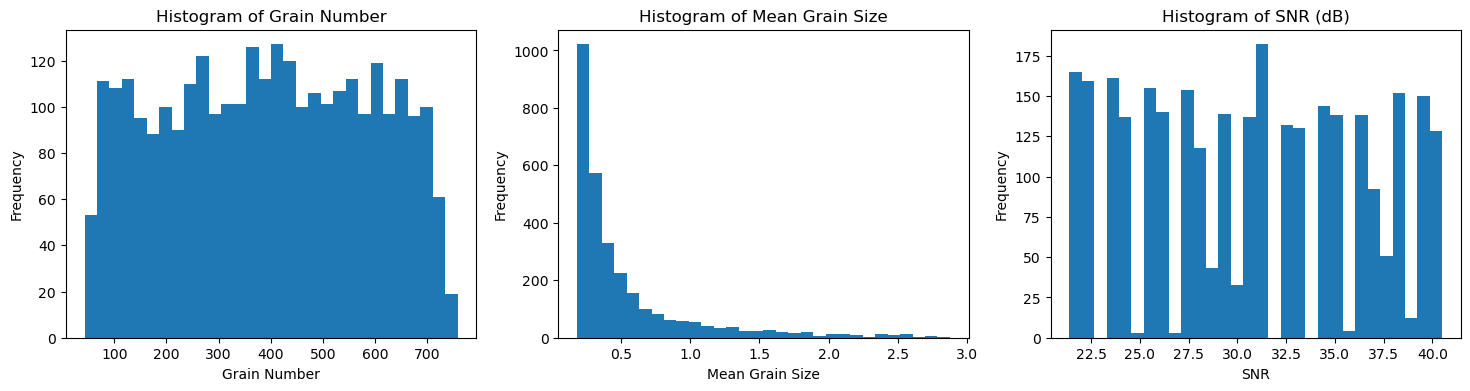

In [4]:
grain_numbers = dataset_noisy.grainmap_df['Grain Number']
grain_sizes = dataset_noisy.grainmap_df['Mean Grain Size']
snr_values = dataset_noisy.grainmap_df['SNR']


grain_number_min, grain_number_max = grain_numbers.min(), grain_numbers.max()
grain_size_min, grain_size_max = grain_sizes.min(), grain_sizes.max()
snr_min, snr_max = snr_values.min(), snr_values.max()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4)) # plot the histograms
ax1.hist(grain_numbers, bins=30, range=(grain_number_min, grain_number_max))
ax1.set_xlabel('Grain Number')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Grain Number')

ax2.hist(grain_sizes, bins=30, range=(grain_size_min, grain_size_max))
ax2.set_xlabel('Mean Grain Size')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Mean Grain Size')

ax3.hist(snr_values, bins=30, range=(snr_min, snr_max))
ax3.set_xlabel('SNR')
ax3.set_ylabel('Frequency')
ax3.set_title('Histogram of SNR (dB)')

plt.show()


In [5]:
# Training test, and validation split
train_size = int(0.8 * len(dataset_noisy))
test_size = len(dataset_noisy) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_noisy, [train_size, test_size])
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=0)

print("[INFO] Train set size:", len(train_loader.dataset))
print("[INFO] Validation set size:", len(val_loader.dataset))
print("[INFO] Test set size:", len(test_loader.dataset))


[INFO] Train set size: 1920
[INFO] Validation set size: 480
[INFO] Test set size: 600


# Display some of the training images:
<p>Some example training data and their labels are displayed below.</p>

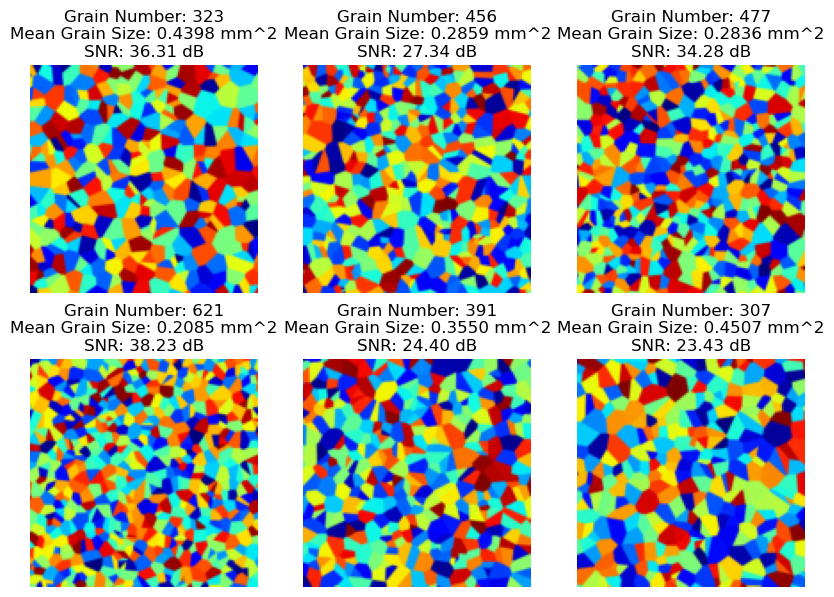

In [6]:
indices = torch.randint(len(train_dataset), size=(6,))  # select 6 random indices from the training set

images = [train_dataset[i][0] for i in indices]  # retrieve the corresponding images, labels, and SNR values
grain_number_labels = [train_dataset[i][1] for i in indices]
grain_size_labels = [train_dataset[i][2] for i in indices]
snr_values = [train_dataset[i][3] for i in indices]

for i in range(6):
    images[i] = ((images[i] * 0.5) + 0.5) * 255  # Unnormalize and scale to 0-255
    grain_number_labels[i] = (grain_number_labels[i] * train_dataset.dataset.dataset.grain_number_std) + train_dataset.dataset.dataset.grain_number_mean
    grain_size_labels[i] = (grain_size_labels[i] * train_dataset.dataset.dataset.grain_size_std) + train_dataset.dataset.dataset.grain_size_mean


fig, axs = plt.subplots(2, 3, figsize=(10, 7))
axs = axs.flatten()
for i in range(6):
    axs[i].imshow(images[i].permute(1, 2, 0).numpy().astype(np.uint8))
    axs[i].set_title('Grain Number: {:.0f}\nMean Grain Size: {:.4f} mm^2\nSNR: {:.2f} dB'.format(grain_number_labels[i], grain_size_labels[i], snr_values[i]))
    axs[i].axis('off')
plt.show()


# GrainMapNet network architecture for predict grain number and grain size simultaneously

In [7]:
class GrainMapNet(nn.Module):
    def __init__(self):
        super(GrainMapNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 1)
        self.fc3 = nn.Linear(256, 1)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.bn4(x) # 4 conv layers
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 128 * 8 * 8) # flatten the output
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.dropout(x)
        x_grain_number = self.fc2(x) # output for grain number
        x_grain_size = self.fc3(x) # output for mean grain size
        return x_grain_number, x_grain_size
    
    def get_mid_layer_outputs(self, x):
        conv1_output, conv2_output, conv3_output, conv4_output = None, None, None, None
        
        x = F.relu(self.bn1(self.conv1(x)))
        conv1_output = self.pool(x)
        x = F.relu(self.bn2(self.conv2(conv1_output)))
        conv2_output = self.pool(x)
        x = F.relu(self.bn3(self.conv3(conv2_output)))
        conv3_output = self.pool(x)
        conv4_output = self.pool(F.relu(self.bn4(self.conv4(conv3_output))))
        
        return conv1_output, conv2_output, conv3_output, conv4_output

grain_map_analysis_model = GrainMapNet().to(device)
print(grain_map_analysis_model)

criterion = nn.MSELoss()
optimizer = optim.Adam(grain_map_analysis_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)


GrainMapNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


# Some helper functions for training the model for both grain number and mean grain size prediction:

In [8]:
def train_epoch_grain_map(model, dataloader, criterion_grain_num, criterion_grain_size, optimizer, device):
    model.train()
    grain_number_loss = 0.0
    grain_size_loss = 0.0
    
    for images, grain_number_labels, grain_size_labels, _ in dataloader:
        images, grain_number_labels, grain_size_labels = images.to(device), grain_number_labels.to(device), grain_size_labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss_grain_number = criterion_grain_num(outputs[0].squeeze(), grain_number_labels.float().squeeze())
        loss_grain_size = criterion_grain_size(outputs[1].squeeze(), grain_size_labels.float().squeeze())

        loss = loss_grain_number + loss_grain_size
        loss.backward()
        optimizer.step()
        grain_number_loss += loss_grain_number.item() * images.size(0)
        grain_size_loss += loss_grain_size.item() * images.size(0)
        
    return grain_number_loss / len(dataloader.dataset), grain_size_loss / len(dataloader.dataset) # return 2 losses


def val_epoch_grain_map(model, dataloader, criterion_grain_num, criterion_grain_size, device):
    model.eval()
    grain_number_loss = 0.0
    grain_size_loss = 0.0

    with torch.no_grad():
        for images, grain_num_labels, grain_size_labels, _ in dataloader:
            images = images.to(device)
            grain_num_labels = grain_num_labels.to(device)
            grain_size_labels = grain_size_labels.to(device)

            grain_num_outputs, grain_size_outputs = model(images)
            loss_grain_num = criterion_grain_num(grain_num_outputs.squeeze(), grain_num_labels.float().squeeze())
            loss_grain_size = criterion_grain_size(grain_size_outputs.squeeze(), grain_size_labels.float().squeeze())


            grain_number_loss += loss_grain_num.item() * images.size(0)
            grain_size_loss += loss_grain_size.item() * images.size(0)

    return grain_number_loss / len(dataloader.dataset), grain_size_loss / len(dataloader.dataset) # return 2 losses


def evaluate_grain_map(model, dataloader, device):
    model.eval()
    grain_num_preds = []
    grain_num_ground_truth = []
    grain_size_preds = []
    grain_size_ground_truth = []

    with torch.no_grad():
        for images, grain_num_labels, grain_size_labels, _ in dataloader:
            images = images.to(device)
            grain_num_labels = grain_num_labels.to(device)
            grain_size_labels = grain_size_labels.to(device)

            grain_num_outputs, grain_size_outputs = model(images)

            grain_num_preds.extend((grain_num_outputs.cpu() * dataset_noisy.grain_number_std + dataset_noisy.grain_number_mean).numpy()) # unnoarmlize the labels
            grain_num_ground_truth.extend((grain_num_labels.cpu() * dataset_noisy.grain_number_std + dataset_noisy.grain_number_mean).numpy())
            grain_size_preds.extend((grain_size_outputs.cpu() * dataset_noisy.grain_size_std + dataset_noisy.grain_size_mean).numpy())
            grain_size_ground_truth.extend((grain_size_labels.cpu() * dataset_noisy.grain_size_std + dataset_noisy.grain_size_mean).numpy())

    return grain_num_preds, grain_num_ground_truth, grain_size_preds, grain_size_ground_truth



def plot_activation_map(model, input_image, layer_number):
    activations = []
    def get_activations_hook(module, input, output):
        activations.append(output.detach())
    selected_layer = model._modules[f'conv{layer_number}']
    hook_handle = selected_layer.register_forward_hook(get_activations_hook)
    input_image = input_image.unsqueeze(0) # feed the input image to the model to get the output
    model.eval()
    with torch.no_grad():
        model(input_image)
    activation_map = activations[0].squeeze().cpu().numpy() # get the activation map
    hook_handle.remove() 
    
    return activation_map.sum(axis=0)



# Training loop for fitting the image with grain number labels and mean grain size labels

[INFO] Epoch: 1/30, Grain Number Train Loss: 2.8951, Grain Number Validation Loss: 0.0780, Mean Grain Size Train Loss: 0.6437, Mean Grain Size Validation Loss: 0.3255
[INFO] Epoch: 2/30, Grain Number Train Loss: 0.1641, Grain Number Validation Loss: 0.0580, Mean Grain Size Train Loss: 0.3079, Mean Grain Size Validation Loss: 0.2015
[INFO] Epoch: 3/30, Grain Number Train Loss: 0.1620, Grain Number Validation Loss: 0.0615, Mean Grain Size Train Loss: 0.2195, Mean Grain Size Validation Loss: 0.1092
[INFO] Epoch: 4/30, Grain Number Train Loss: 0.1648, Grain Number Validation Loss: 0.3139, Mean Grain Size Train Loss: 0.2103, Mean Grain Size Validation Loss: 0.1342
[INFO] Epoch: 5/30, Grain Number Train Loss: 0.1807, Grain Number Validation Loss: 0.1152, Mean Grain Size Train Loss: 0.2008, Mean Grain Size Validation Loss: 0.1587
[INFO] Epoch: 6/30, Grain Number Train Loss: 0.1798, Grain Number Validation Loss: 0.1878, Mean Grain Size Train Loss: 0.1963, Mean Grain Size Validation Loss: 0.146

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


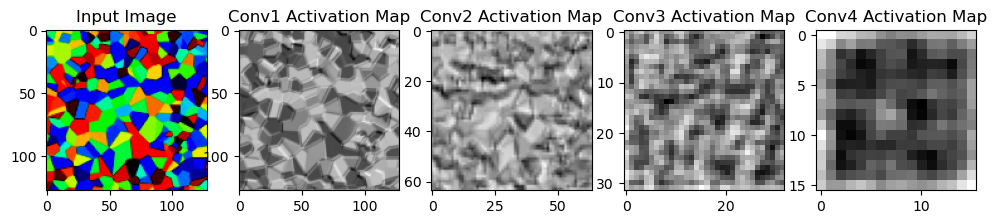

[INFO] Epoch: 11/30, Grain Number Train Loss: 0.1267, Grain Number Validation Loss: 0.0517, Mean Grain Size Train Loss: 0.1467, Mean Grain Size Validation Loss: 0.0497
[INFO] Epoch: 12/30, Grain Number Train Loss: 0.1250, Grain Number Validation Loss: 0.0248, Mean Grain Size Train Loss: 0.1649, Mean Grain Size Validation Loss: 0.0625
[INFO] Epoch: 13/30, Grain Number Train Loss: 0.1268, Grain Number Validation Loss: 0.0498, Mean Grain Size Train Loss: 0.1523, Mean Grain Size Validation Loss: 0.0525
[INFO] Epoch: 14/30, Grain Number Train Loss: 0.1261, Grain Number Validation Loss: 0.0648, Mean Grain Size Train Loss: 0.1403, Mean Grain Size Validation Loss: 0.0849
[INFO] Epoch: 15/30, Grain Number Train Loss: 0.1204, Grain Number Validation Loss: 0.0457, Mean Grain Size Train Loss: 0.1406, Mean Grain Size Validation Loss: 0.0798
[INFO] Epoch: 16/30, Grain Number Train Loss: 0.1225, Grain Number Validation Loss: 0.1093, Mean Grain Size Train Loss: 0.1294, Mean Grain Size Validation Loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


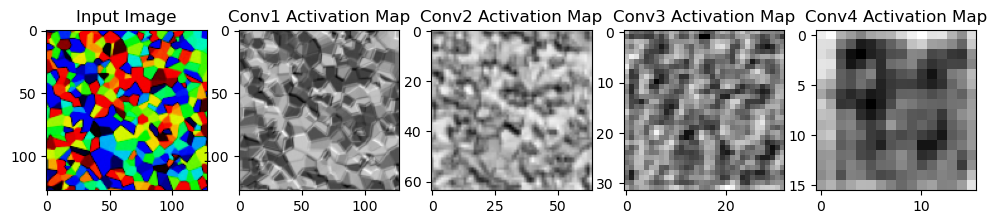

[INFO] Epoch: 21/30, Grain Number Train Loss: 0.1214, Grain Number Validation Loss: 0.0249, Mean Grain Size Train Loss: 0.0894, Mean Grain Size Validation Loss: 0.0427
[INFO] Epoch: 22/30, Grain Number Train Loss: 0.1053, Grain Number Validation Loss: 0.0301, Mean Grain Size Train Loss: 0.0939, Mean Grain Size Validation Loss: 0.0393
[INFO] Epoch: 23/30, Grain Number Train Loss: 0.1035, Grain Number Validation Loss: 0.0592, Mean Grain Size Train Loss: 0.0998, Mean Grain Size Validation Loss: 0.0565
[INFO] Epoch: 24/30, Grain Number Train Loss: 0.1096, Grain Number Validation Loss: 0.0540, Mean Grain Size Train Loss: 0.0959, Mean Grain Size Validation Loss: 0.0476
[INFO] Epoch: 25/30, Grain Number Train Loss: 0.1000, Grain Number Validation Loss: 0.0581, Mean Grain Size Train Loss: 0.1047, Mean Grain Size Validation Loss: 0.0561
Epoch 00026: reducing learning rate of group 0 to 2.5000e-04.
[INFO] Epoch: 26/30, Grain Number Train Loss: 0.1062, Grain Number Validation Loss: 0.0581, Mean G

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


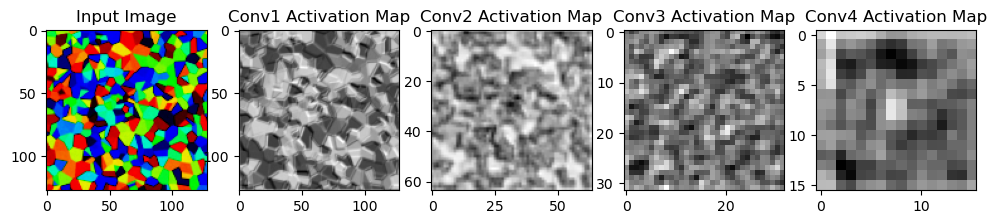

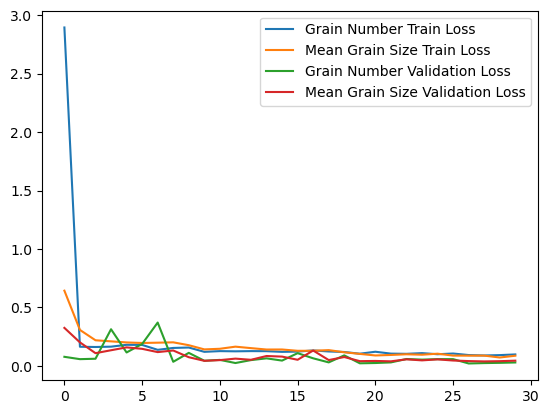

[INFO] Final train loss for grain number prediction: 0.0983
[INFO] Final validation loss for grain number prediction: 0.0296
[INFO] Final train loss for mean grain size prediction: 0.0450
[INFO] Final validation loss for mean grain size prediction: 0.0873


In [9]:
train_losses_grain_num = []
train_losses_grain_size = []
val_losses_grain_num = []
val_losses_grain_size = []

n_epochs = 30
best_val_loss = float('inf')

visualization_epoch = 10 # the epoch to plot the activation map for each conv layer.

for epoch in range(n_epochs):
    grain_num_train_loss, grain_size_train_loss = train_epoch_grain_map(grain_map_analysis_model, train_loader, criterion, criterion, optimizer, device)
    grain_num_val_loss, grain_size_val_loss = val_epoch_grain_map(grain_map_analysis_model, val_loader, criterion, criterion, device)
    scheduler.step(grain_num_val_loss)

    print("[INFO] Epoch: {}/{}, Grain Number Train Loss: {:.4f}, Grain Number Validation Loss: {:.4f}, Mean Grain Size Train Loss: {:.4f}, Mean Grain Size Validation Loss: {:.4f}".format(epoch+1, n_epochs, grain_num_train_loss, grain_num_val_loss, grain_size_train_loss, grain_size_val_loss))

    if (epoch + 1) % visualization_epoch == 0: # plot activation maps for every conv layer
        input_image, _, _, _= next(iter(train_loader))
        input_image = input_image.to(device)
        activation_map_1 = plot_activation_map(grain_map_analysis_model, input_image[0], 1)
        activation_map_2 = plot_activation_map(grain_map_analysis_model, input_image[0], 2)
        activation_map_3 = plot_activation_map(grain_map_analysis_model, input_image[0], 3)
        activation_map_4 = plot_activation_map(grain_map_analysis_model, input_image[0], 4)

        fig, axs = plt.subplots(1, 5, figsize=(12, 3)) # plot sample image, conv1-4 activation maps in one figure
        axs[0].imshow(input_image[0].cpu().numpy().transpose(1, 2, 0))
        axs[0].set_title('Input Image')
        axs[1].imshow(activation_map_1, cmap='gray')
        axs[1].set_title('Conv1 Activation Map')
        axs[2].imshow(activation_map_2, cmap='gray')
        axs[2].set_title('Conv2 Activation Map')
        axs[3].imshow(activation_map_3, cmap='gray')
        axs[3].set_title('Conv3 Activation Map')
        axs[4].imshow(activation_map_4, cmap='gray')
        axs[4].set_title('Conv4 Activation Map')
        plt.show()

    if (grain_num_val_loss + grain_size_val_loss) / 2 < best_val_loss:
        best_val_loss = (grain_num_val_loss + grain_size_val_loss) / 2
        torch.save(grain_map_analysis_model.state_dict(), 'best_grain_map_model_on_noisy.pth') # save the model with the best validation loss for both predictions

    train_losses_grain_num.append(grain_num_train_loss)
    train_losses_grain_size.append(grain_size_train_loss)
    val_losses_grain_num.append(grain_num_val_loss)
    val_losses_grain_size.append(grain_size_val_loss)

plt.plot(train_losses_grain_num, label='Grain Number Train Loss')
plt.plot(train_losses_grain_size, label='Mean Grain Size Train Loss')
plt.plot(val_losses_grain_num, label='Grain Number Validation Loss')
plt.plot(val_losses_grain_size, label='Mean Grain Size Validation Loss')
plt.legend()
plt.show()

final_train_loss_grain_num = train_losses_grain_num[-1]
final_val_loss_grain_num = val_losses_grain_num[-1]
final_train_loss_grain_size = val_losses_grain_size[-1]
final_val_loss_grain_size= train_losses_grain_size[-1]
print("[INFO] Final train loss for grain number prediction: {:.4f}".format(final_train_loss_grain_num))
print("[INFO] Final validation loss for grain number prediction: {:.4f}".format(final_val_loss_grain_num))
print("[INFO] Final train loss for mean grain size prediction: {:.4f}".format(final_train_loss_grain_size))
print("[INFO] Final validation loss for mean grain size prediction: {:.4f}".format(final_val_loss_grain_size))



# Evaluation


<p>Plot the feature maps for conv1 conv2 conv3 conv4 (4 randomly selected channels for each conv layer).</p>

<p>Evaluate the regression results.</p>

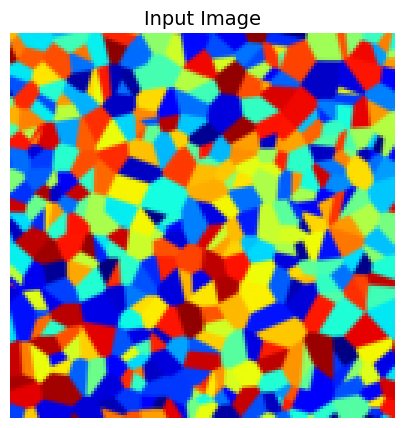

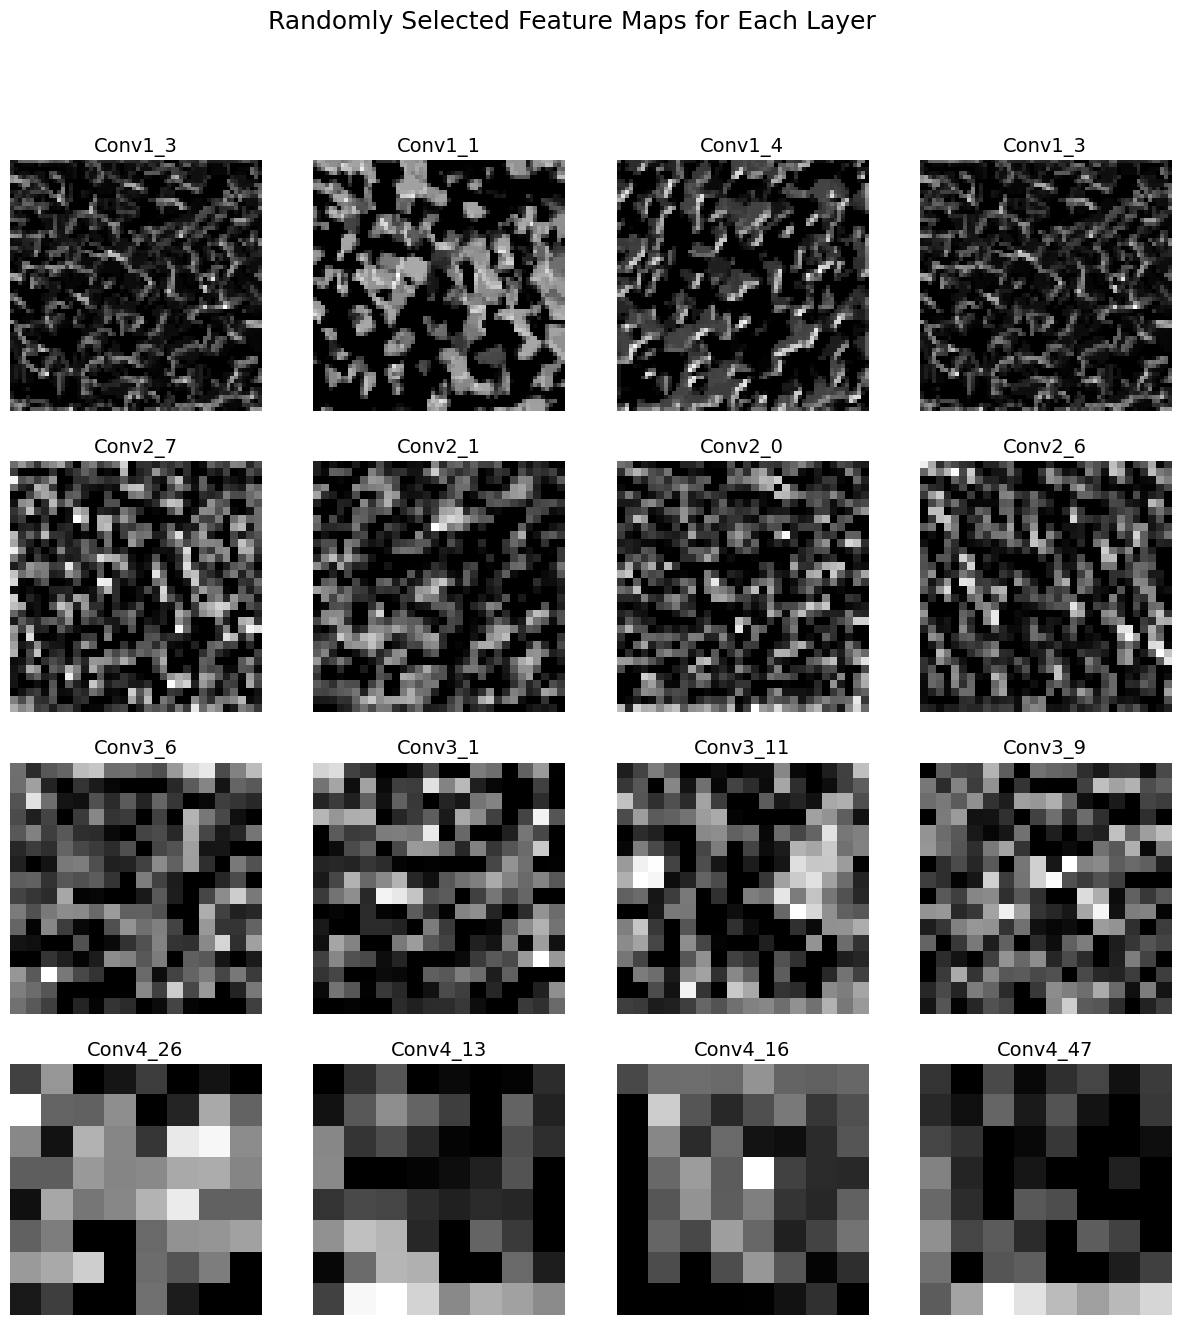

[INFO] Grain Number Mean Squared Error (MSE): 770.5330
[INFO] Grain Number Mean Absolute Error (MAE): 22.0553
[INFO] Grain Number R-squared (R2): 0.9793
[INFO] Mean Grain Size Mean Squared Error (MSE): 0.0081
[INFO] Mean Grain Size Mean Absolute Error (MAE): 0.0512
[INFO] Mean Grain Size R-squared (R2): 0.9587


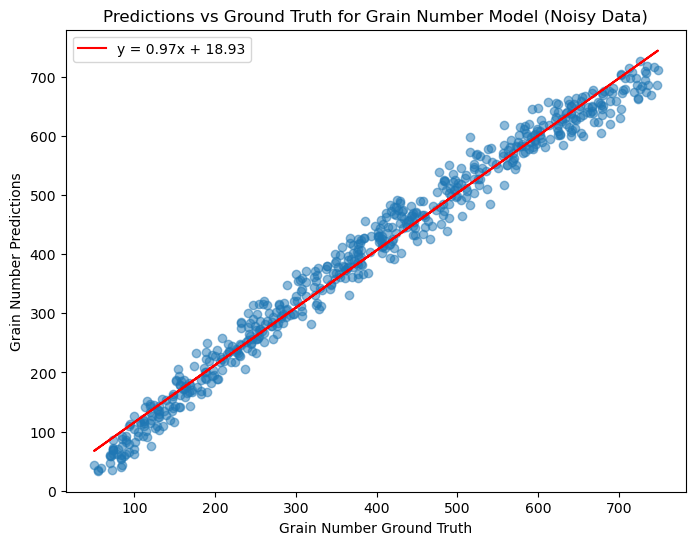

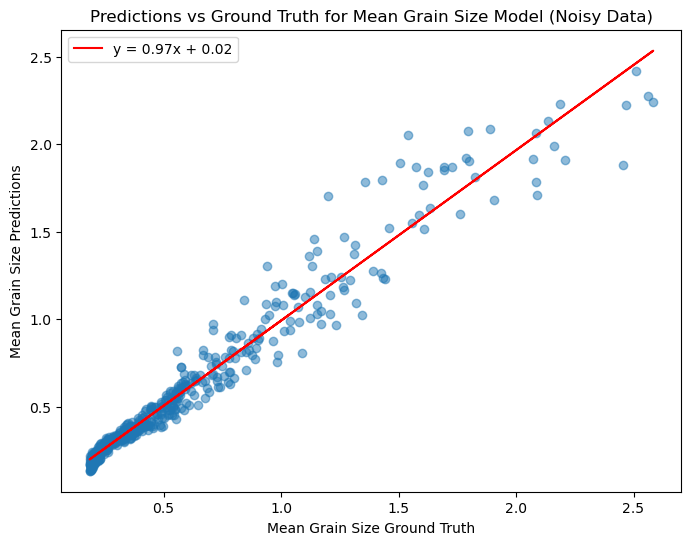

In [10]:
def unnormalize_image(image, mean, std):
    unnormalized_image = image.clone().detach()
    for image_tensor, mean, std in zip(unnormalized_image, mean, std):
        image_tensor.mul_(mean).add_(std) # unnormalize the image tensor for show
    return unnormalized_image

def visualize_mid_layer_analysis(model, dataloader, device):
    input_image, _, _, _ = next(iter(dataloader))
    input_image = input_image.to(device)
    conv1_output, conv2_output, conv3_output, conv4_output = model.get_mid_layer_outputs(input_image)

    conv1_maps = torch.randint(low=0, high=8, size=(4,))
    conv2_maps = torch.randint(low=0, high=16, size=(4,))
    conv3_maps = torch.randint(low=0, high=32, size=(4,))
    conv4_maps = torch.randint(low=0, high=64, size=(4,))

    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5] # reverse transform
    
    unnormalized_input_image = unnormalize_image(input_image[0], mean, std).cpu().numpy() # unnormalize the input image
    unnormalized_input_image = np.clip(unnormalized_input_image, 0, 1)


    fig, axs = plt.subplots(1, 1, figsize=(5, 5))     # plot the input image
    axs.imshow(unnormalized_input_image.transpose(1, 2, 0))
    axs.set_title('Input Image', fontsize=14)  
    axs.axis('off')


    fig, axs = plt.subplots(4, 4, figsize=(15, 15))
    for i in range(4):
        axs[0, i].imshow(conv1_output[0, conv1_maps[i]].detach().cpu().numpy(), cmap='gray')     # Plot the 4x4 feature maps
        axs[0, i].set_title(f'Conv1_{conv1_maps[i]}', fontsize=14)
        axs[0, i].axis('off')
        axs[1, i].imshow(conv2_output[0, conv2_maps[i]].detach().cpu().numpy(), cmap='gray')
        axs[1, i].set_title(f'Conv2_{conv2_maps[i]}', fontsize=14)
        axs[1, i].axis('off')
        axs[2, i].imshow(conv3_output[0, conv3_maps[i]].detach().cpu().numpy(), cmap='gray')
        axs[2, i].set_title(f'Conv3_{conv3_maps[i]}', fontsize=14)
        axs[2, i].axis('off')
        axs[3, i].imshow(conv4_output[0, conv4_maps[i]].detach().cpu().numpy(), cmap='gray')
        axs[3, i].set_title(f'Conv4_{conv4_maps[i]}', fontsize=14)
        axs[3, i].axis('off')
    fig.suptitle('Randomly Selected Feature Maps for Each Layer', fontsize=18)
    plt.show()




grain_map_analysis_model.load_state_dict(torch.load('best_grain_map_model_on_noisy.pth')) # load the trained models (Models trained on noisy data)
visualize_mid_layer_analysis(grain_map_analysis_model, train_loader, device)  # Visualize mid-layer analysis

predictions_grain_num, ground_truth_grain_num, predictions_grain_size, ground_truth_grain_size = evaluate_grain_map(grain_map_analysis_model, test_loader, device) #return predictions and ground-truth

mse_grain_num = mean_squared_error(ground_truth_grain_num, predictions_grain_num)
mae_grain_num = mean_absolute_error(ground_truth_grain_num, predictions_grain_num)
r2_grain_num = r2_score(ground_truth_grain_num, predictions_grain_num)

print("[INFO] Grain Number Mean Squared Error (MSE): {:.4f}".format(mse_grain_num))
print("[INFO] Grain Number Mean Absolute Error (MAE): {:.4f}".format(mae_grain_num))
print("[INFO] Grain Number R-squared (R2): {:.4f}".format(r2_grain_num))

mse_grain_size = mean_squared_error(ground_truth_grain_size, predictions_grain_size)
mae_grain_size = mean_absolute_error(ground_truth_grain_size, predictions_grain_size)
r2_grain_size = r2_score(ground_truth_grain_size, predictions_grain_size)

print("[INFO] Mean Grain Size Mean Squared Error (MSE): {:.4f}".format(mse_grain_size))
print("[INFO] Mean Grain Size Mean Absolute Error (MAE): {:.4f}".format(mae_grain_size))
print("[INFO] Mean Grain Size R-squared (R2): {:.4f}".format(r2_grain_size))

a_grain_num, b_grain_num = np.polyfit(ground_truth_grain_num, predictions_grain_num, 1)
a_grain_size, b_grain_size = np.polyfit(ground_truth_grain_size, predictions_grain_size, 1)
a_grain_num_func = a_grain_num.item()
b_grain_num_func = b_grain_num.item()
a_grain_size_func = a_grain_size.item()
b_grain_size_func = b_grain_size.item()
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(ground_truth_grain_num, predictions_grain_num, alpha=0.5)
ax.plot(np.array(ground_truth_grain_num), a_grain_num_func * np.array(ground_truth_grain_num) + b_grain_num_func, color='red', label=f'y = {a_grain_num_func:.2f}x + {b_grain_num_func:.2f}')
ax.set_xlabel('Grain Number Ground Truth')
ax.set_ylabel('Grain Number Predictions')
ax.set_title('Predictions vs Ground Truth for Grain Number Model (Noisy Data)')
ax.legend()
plt.show()
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(ground_truth_grain_size, predictions_grain_size, alpha=0.5)
ax.plot(np.array(ground_truth_grain_size), a_grain_size_func * np.array(ground_truth_grain_size) + b_grain_size_func, color='red', label=f'y = {a_grain_size_func:.2f}x + {b_grain_size_func:.2f}')
ax.set_xlabel('Mean Grain Size Ground Truth')
ax.set_ylabel('Mean Grain Size Predictions')
ax.set_title('Predictions vs Ground Truth for Mean Grain Size Model (Noisy Data)')
ax.legend()
plt.show()

# Plot some sample test results


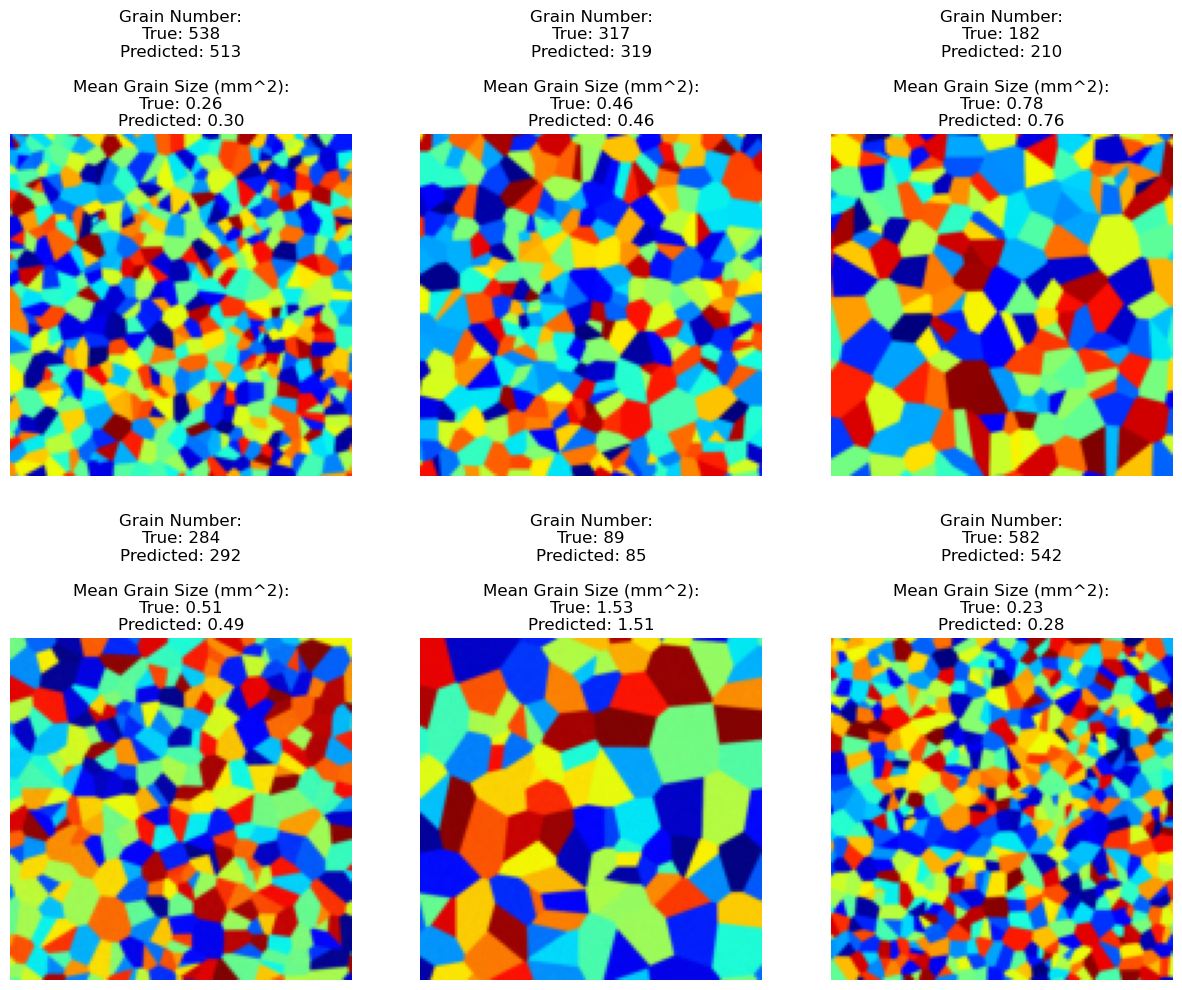

In [10]:
indices = torch.randint(len(test_dataset), size=(6,))  # randomly select 6 image (indices) from the test dataset

images = [test_dataset[i][0] for i in indices] # find 6 random images
ground_truth = [test_dataset[i][1] for i in indices]
ground_truth_grain_size = [test_dataset[i][2] for i in indices]
images_tensor = torch.stack(images).to(device)
predictions_tensor = grain_map_analysis_model(images_tensor)
grain_number_predictions = predictions_tensor[0].view(-1).cpu().detach().numpy()
mean_grain_size_predictions = predictions_tensor[1].view(-1).cpu().detach().numpy()

for i in range(6):
    images[i] = ((images[i] * 0.5) + 0.5) * 255  # unnormalize and scale to 0-255

fig, axs = plt.subplots(2, 3, figsize=(15, 12))  # plot the images along with the ground truth and predicted grain numbers
axs = axs.flatten()

for i in range(6):
    axs[i].imshow(images[i].permute(1, 2, 0).numpy().astype(np.uint8))
   
    unnormalized_prediction_grain_num = int(np.round(grain_number_predictions[i] * dataset_noisy.grain_number_std + dataset_noisy.grain_number_mean))  # unnormalize grain number label predictions and ground truth
    unnormalized_ground_truth_grain_num = int(ground_truth[i] * dataset_noisy.grain_number_std + dataset_noisy.grain_number_mean)
    unnormalized_prediction_grain_size = mean_grain_size_predictions[i] * dataset_noisy.grain_size_std + dataset_noisy.grain_size_mean
    unnormalized_ground_truth_grain_size = ground_truth_grain_size[i] * dataset_noisy.grain_size_std + dataset_noisy.grain_size_mean     # Unnormalize mean grain size label predictions and ground truth

    axs[i].set_title('Grain Number:\nTrue: {}\nPredicted: {}\n\nMean Grain Size (mm^2):\nTrue: {:.2f}\nPredicted: {:.2f}'.format(
        unnormalized_ground_truth_grain_num, unnormalized_prediction_grain_num,
        unnormalized_ground_truth_grain_size, unnormalized_prediction_grain_size))
    axs[i].axis('off')

plt.show()
